In [1]:
# import pandas as pd
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from Tools import hierarchical_contrastive_loss
# from Networks import TrEncoder
# from Evaluations import fit_svm
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import average_precision_score
# import copy
# from tqdm import tqdm

In [1]:
import numpy as np
import torch

from Dataprocessing import data_provider
from Tr2Vec import Tr2Vec

import time
import easydict

In [2]:
args = easydict.EasyDict({
    'model': 'C', # ['C', 'F'], C for Classification, F for Forecasting
    'path': './Data/3D/',
    'ratio': [7, 1, 2],
    'seq_len': 2656, # [2144, 4576, 2656] # 3200 in paper
    'pred_len': 100,
    'slice_len': 100, 
    'hidden_dims': 64,
    'repr_dims': 320,
    'slicing': True,
    'slice_stride': 10,
    'channel_num': 23,
    'class_num': 5,
    'layer_num': 10, # Res block number
    'individual': False,
    'num_workers': 8,
    'batch_size': 8,
    'lr': 0.001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'debug': False,
    
    # No touch
    'temporal_unit': 0,
    'max_train_length': 3000,
})
    
if args.model == 'F':
    args.seq_len = 100

is_individual = 'indiv' if args.individual else 'joint'
args.checkpoint = f'./Checkpoint/{time.strftime('%Y-%m-%d', time.localtime(time.time()))}_E_{is_individual}_h{args.hidden_dims}_r{args.repr_dims}_l{args.layer_num}_in{args.seq_len}_ch{args.channel_num}'
args.loadpoint = './Checkpoint/2024-05-31_E_indiv_h64_r320_l10_in2656_ch23.ckpt' # << 3000 iter (~ 13 epochs) trained individual model
# loadpoint = './Checkpoint/2024-06-02_E_indiv_h64_r320_l10_in2656_ch23.ckpt' # << 1 iter (~ under 1 epochs) trained individual model
# loadpoint = './Checkpoint/2024-06-13_E_joint_h64_r320_l10_in2656_ch23.ckpt' # << 3000 iter (~ 13 epochs) trained joint model

In [3]:
trainset, trainloader = data_provider(args, 'train') # 'train', 'val', 'test'
trainset.data_x.shape, trainset.data_y.shape

((1750, 2656, 24), (1750,))

In [4]:
testset, testloader = data_provider(args, 'test') # 'train', 'val', 'test'
testset.data_x.shape, testset.data_y.shape

((95543, 100, 24), (95543,))

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import seaborn as sns
# import pandas as pd
from Evaluations import fit_svm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

tr2vec = Tr2Vec(args=args)
# tr2vec.load(args.loadpoint)
tr2vec.train(trainset, n_epochs=1000, n_iters=218750)
tr2vec.save(args.checkpoint+'.ckpt')
# out, eval_res = tr2vec.eval(trainset, testset)

train_repr = tr2vec.encode(trainset.data_x)
test_repr = tr2vec.encode(testset.data_x)

clf = fit_svm(train_repr, trainset.data_y)
acc = clf.score(test_repr, testset.data_y)
y_score = clf.decision_function(test_repr)
test_labels_onehot = label_binarize(testset.data_y, classes=np.arange(trainset.data_y.max()+1))
auprc = average_precision_score(test_labels_onehot, y_score)
out, eval_res = y_score, { 'acc': acc, 'auprc': auprc }

print('Evaluation result:', eval_res)
# Evaluation result: {'acc': 0.996, 'auprc': 0.9989302325581395} for 3000 iter trained individual model
# Evaluation result: {'acc': 0.994, 'auprc': 0.9969543433382899} for 1 iter trained individual model 8 batch size
# Evaluation result: {'acc': 0.998, 'auprc': 0.9973443052914563} for 3000 iter trained joint model

epoch: 0
Model saved at epoch 0
iter: 0


c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

epoch: 0
iter: 0


c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\전규효\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


iter: 100
iter: 200
Epoch #None: loss=24733.41394959021
epoch: 1
iter: 300
iter: 400
Epoch #None: loss=10.46732145930649
epoch: 2
iter: 500
iter: 600
Epoch #None: loss=5.078319767199525
epoch: 3
iter: 700
iter: 800
Epoch #None: loss=3.7468674915646196
epoch: 4
iter: 900
iter: 1000
Epoch #None: loss=3.326877618054731
epoch: 5
iter: 1100
iter: 1200
iter: 1300
Epoch #None: loss=3.2120289561945365
epoch: 6
iter: 1400
iter: 1500
Epoch #None: loss=3.1491097080598185
epoch: 7
iter: 1600
iter: 1700
Epoch #None: loss=3.0527496031664927
epoch: 8
iter: 1800
iter: 1900
Epoch #None: loss=3.150567023032302
epoch: 9
iter: 2000
iter: 2100
Epoch #None: loss=2.975165320098947
epoch: 10
iter: 2200
iter: 2300
Epoch #None: loss=2.999290298978123
epoch: 11
iter: 2400
iter: 2500
iter: 2600
Epoch #None: loss=2.9451880050361705
epoch: 12
iter: 2700
iter: 2800
Epoch #None: loss=2.920592902997218
epoch: 13
iter: 2900
iter: 3000
Epoch #None: loss=2.8753184561335714
epoch: 14
iter: 3100
iter: 3200
Epoch #None: los

: 

C:\Users\전규효\AppData\Local\Temp\ipykernel_3100\3490093623.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(pca_comp[i*100:i*100+100, 0], pca_comp[i*100:i*100+100, 1],
C:\Users\전규효\AppData\Local\Temp\ipykernel_3100\3490093623.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1].scatter(tsne_comp[i*100:i*100+100,0], tsne_comp[i*100:i*100+100,1],


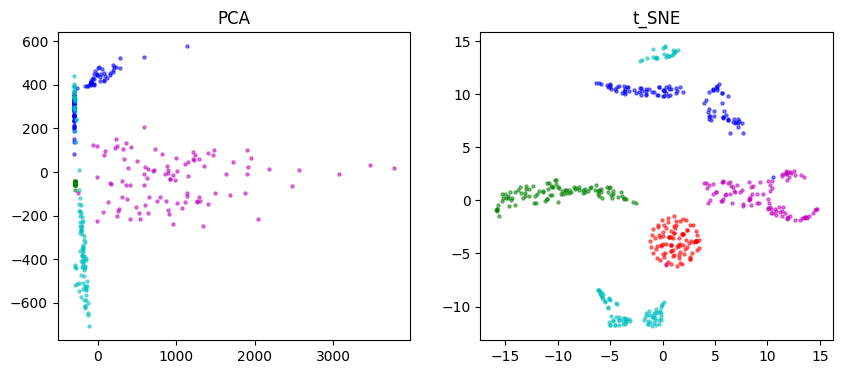

In [53]:
from sklearn.datasets import load_digits
from matplotlib import animation

class_names = ['N', 'BT', 'XE', "TV", 'FB']
colors = ['r', 'g', 'b', 'c', 'm']
pred = clf.predict(test_repr)
pca = PCA(n_components=3)
tsne = TSNE(n_components=3)
pca_comp = pca.fit_transform(test_repr)
tsne_comp = tsne.fit_transform(test_repr)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
for i in range(5):
    axs[0].set_title("PCA")
    axs[0].scatter(pca_comp[i*100:i*100+100, 0], pca_comp[i*100:i*100+100, 1], 
                   color=colors[i], cmap="inferno", s=5, alpha=0.5, label=class_names[i])
    axs[1].set_title("t_SNE")
    axs[1].scatter(tsne_comp[i*100:i*100+100,0], tsne_comp[i*100:i*100+100,1], 
                   color=colors[i], cmap="inferno", s=5, alpha=0.5, label=class_names[i])
# axs[0].legend()
# axs[1].legend()
plt.show()

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={"projection":"3d"})

def init():
    for ax, data in zip(axs, [pca_comp, tsne_comp]):
        title = "PCA" if ax == axs[0] else "t_SNE"
        ax.set_title(title)
        for i in range(5):
            ax.scatter(data[i*100:i*100+100, 0], data[i*100:i*100+100, 1], data[i*100:i*100+100, 2], 
                        color=colors[i], cmap="inferno", s=5, alpha=0.5)
    return fig,

def animate(i):
    axs[0].view_init(elev=30., azim=i)
    axs[1].view_init(elev=30., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
anim.save('mpl3d_scatter.gif', fps=30)

----------------------------------------------------------------------
Accuracy | AUROC_i | AUROC_a | AUPRC_i | AUPRC_a |    f1_i |    f1_a |
  0.9960 |  0.9989 |  0.9994 |  0.9983 |  0.9989 |  0.9960 |  0.9960 |
Accuracy for classes
      0 |       1 |       2 |       3 |       4 |
  99.60 &   99.80 &   100.0 &   100.0 &   99.80 & 
F1 Score for classes
      0 |       1 |       2 |       3 |       4 |
 0.9901 &  0.9950 &  1.0000 &  1.0000 &  0.9950 & 


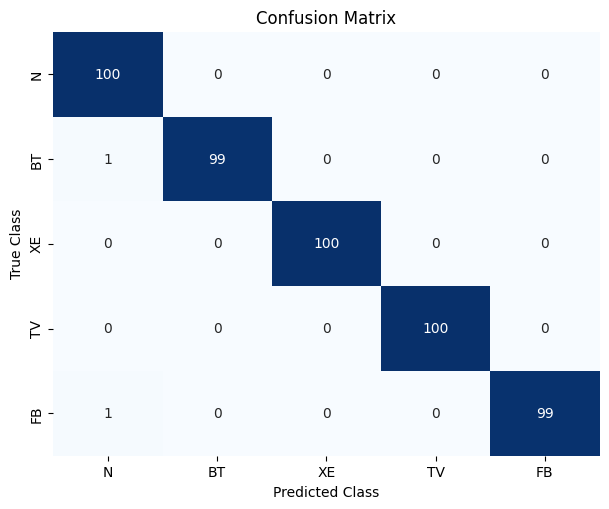

0.996 0.996 0.996


In [45]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score, f1_score
import pandas as pd
import seaborn as sns

preds = clf.predict(test_repr)
targs = testset.data_y 

y_pred = out.argmax(1)
y_true = testset.data_y

correct = (y_pred == y_true).sum().item()
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['N', 'BT', 'XE', "TV", 'FB']
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
accuracy = acc
auroc_i = round(roc_auc_score(test_labels_onehot, y_score, average='micro'), 4)
auroc_a = round(roc_auc_score(test_labels_onehot, y_score, average='macro'), 4)
auprc_i = round(average_precision_score(test_labels_onehot, y_score, average='micro'), 4)
auprc_a = round(average_precision_score(test_labels_onehot, y_score, average='macro'), 4)
f1_a = round(f1_score(y_true, y_pred, average='macro'), 4)
f1_i = round(f1_score(y_true, y_pred, average='micro'), 4)
        
print('-'*70)
print('Accuracy | AUROC_i | AUROC_a | AUPRC_i | AUPRC_a |    f1_i |    f1_a |')
print(' ', format(accuracy, ".4f"), '| ', format(auroc_i, ".4f"), '| ', format(auroc_a, ".4f"), '| ', format(auprc_i, ".4f"), '| ', format(auprc_a, ".4f"), '| ', format(f1_i, ".4f"), '| ', format(f1_a, ".4f"), '|')
print('Accuracy for classes')
print('      0 |       1 |       2 |       3 |       4 |')
for i in range(args.class_num):
    print(' ', format(round(accuracy_score(test_labels_onehot[:,i], np.eye(5)[y_pred][:,i]), 4)*100, ".2f")[:5], end=' & ')
print()
print('F1 Score for classes')
print('      0 |       1 |       2 |       3 |       4 |')
for i in range(args.class_num):
    print('', format(round(f1_score(test_labels_onehot[:,i], np.eye(5)[y_pred][:,i]), 4), ".4f"), end=' & ')
print()

plt.figure(figsize=(6, 5))
sns.heatmap(dataframe, annot=True, cbar=None,cmap="Blues",fmt="d")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()
print(accuracy, f1_i, f1_a)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_forecast_csv(name, univar=False):
    data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)
    dt_embed = _get_time_features(data.index)
    n_covariate_cols = dt_embed.shape[-1]
    
    if univar:
        if name in ('ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'):
            data = data[['OT']]
        elif name == 'electricity':
            data = data[['MT_001']]
        else:
            data = data.iloc[:, -1:]
        
    data = data.to_numpy()
    if name == 'ETTh1' or name == 'ETTh2':
        train_slice = slice(None, 12*30*24)
        valid_slice = slice(12*30*24, 16*30*24)
        test_slice = slice(16*30*24, 20*30*24)
    elif name == 'ETTm1' or name == 'ETTm2':
        train_slice = slice(None, 12*30*24*4)
        valid_slice = slice(12*30*24*4, 16*30*24*4)
        test_slice = slice(16*30*24*4, 20*30*24*4)
    else:
        train_slice = slice(None, int(0.6 * len(data)))
        valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
        test_slice = slice(int(0.8 * len(data)), None)
    
    scaler = StandardScaler().fit(data[train_slice])
    data = scaler.transform(data)
    if name in ('electricity'):
        data = np.expand_dims(data.T, -1)  # Each variable is an instance rather than a feature
    else:
        data = np.expand_dims(data, 0)
    
    if n_covariate_cols > 0:
        dt_scaler = StandardScaler().fit(dt_embed[train_slice])
        dt_embed = np.expand_dims(dt_scaler.transform(dt_embed), 0)
        data = np.concatenate([np.repeat(dt_embed, data.shape[0], axis=0), data], axis=-1)
    
    if name in ('ETTh1', 'ETTh2', 'electricity'):
        pred_lens = [24, 48, 168, 336, 720]
    else:
        pred_lens = [24, 48, 96, 288, 672]
        
    return data, train_slice, valid_slice, test_slice, scaler, pred_lens, n_covariate_cols


def _get_time_features(dt):
    return np.stack([
        dt.minute.to_numpy(),
        dt.hour.to_numpy(),
        dt.dayofweek.to_numpy(),
        dt.day.to_numpy(),
        dt.dayofyear.to_numpy(),
        dt.month.to_numpy(),
        dt.weekofyear.to_numpy(),
    ], axis=1).astype(np.float)